# <center>  Determine the impact of county-wise population density and employment statistics on a child’s future economic status/condition

  </center>

### INTRODUCTION
Child Trends is a research organization focused on improving the lives of children in the US. For Child Trends to make the right impact, it is key to identify the most vulnerable children, needing help. 

### PROJECT GOAL:
Determine the impact on the future economic status/condition of a child, based on the current employment statistics and population density of the county the child lives in.
Based on how these parameters impact the future income of a child, a consolidated list of counties can be prepared, where the children are most vulnerable to a poor economic life and need help from Child Trend.


### TEAM:

 - Karishma Saikia
 - Nithin Kanduri
 - Tampara Dora


### The data sets which were used to integrate with the Opportunity Atlas are-

#### 1.Population Density Data
**SOURCE:** United States Census Bureau https://www.census.gov/population/www/censusdata/files/90den_stco.txt
#### 2. FIPS Code Data
**SOURCE:** https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt
#### 3. Employment Statistics Data
**SOURCE:** United States of Labor Statistics https://www.bls.gov/cew/downloadable-data-files.htm
#### 4. Population Data
**SOURCE:** United States Census Bureau https://www.census.gov/data/tables/time-series/demo/popest/1980s-county.html


### Importing Required Libraries

In [1]:
#importing required Libraries.

import pandas as pd
import matplotlib
import statistics
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error



#to format the state and county names
from difflib import get_close_matches  

import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12});

## STEP 1: Preparation of Data for Integration

The datasets downloaded is cleaned and formatted county wise to merge with opportunity atlas. Data Integration Steps Include-

 - Download the raw data
 - Format the State and County names
 - Changed the columns names into readable format
 - Merged with Opportunity Atlas
 - Dropped the unwanted columns
 - Replaced NA of the merged data



### 1.1 Preparation of Population Density Data:
The population density data was in a PDF format. We copied the text into an excel file and did the integration.


In [2]:
### reading population and area file
population_df=pd.read_excel('pop den.xlsx')
population_df.head()

,pop
0,4040587 131443.1 50750.2 30.7 79.6...
1,34222 1543.7 596.0 22.2 57.4 A...
2,98280 4135.0 1596.5 23.8 61.6 B...
3,25417 2292.1 885.0 11.1 28.7 B...
4,16576 1611.9 622.4 10.3 26.6 B...


In [3]:
def splitColumns(df,col):
    
    """This is a function to split column"""
    
    return df[col].str.replace('\xa0',"").str.split()

population_df['split_columns']=splitColumns(population_df,'pop')

In [4]:
def colCreate(df,colname,index):
    
    """This is a function to create new columns"""
    
    df[colname]=""
    for i in range(len(df)):
        if index==5:
            df[colname][i]=" ".join(df['split_columns'][i][index:])
        else:
            df[colname][i]=df['split_columns'][i][index]



In [5]:
#create new columns

colCreate(population_df,'population',0)
colCreate(population_df,'squareKms',1)
colCreate(population_df,'squareMiles',2)
colCreate(population_df,'State',5)



In [6]:
def dataframe_check(df):
    
    """This is a function that checks the dataframe"""
    
    print(f"The shape is {df.shape}")
    print(f"The columns are {df.columns}")
   
    print("**************************")
    print("Checking the NA values")
    print(df.count())
    print("**************************")
    print("The Datatypes of the columns-")
    print(df.dtypes)
    return(df.head())
   

In [7]:
#deleting unwanted columns
del population_df['pop']
del population_df['split_columns']

In [8]:
dataframe_check(population_df)

The shape is (3192, 4)
The columns are Index(['population', 'squareKms', 'squareMiles', 'State'], dtype='object')
**************************
Checking the NA values
population     3192
squareKms      3192
squareMiles    3192
State          3192
dtype: int64
**************************
The Datatypes of the columns-
population     object
squareKms      object
squareMiles    object
State          object
dtype: object


,population,squareKms,squareMiles,State
0,4040587,131443.1,50750.2,Alabama
1,34222,1543.7,596.0,Autauga County
2,98280,4135.0,1596.5,Baldwin County
3,25417,2292.1,885.0,Barbour County
4,16576,1611.9,622.4,Bibb County


In [9]:
#getting list of all states for mapping and merging it with population file
states_df=pd.read_excel('states.xlsx')
states_df.rename(columns={'States':'State'},inplace=True)
population_df=population_df.merge(states_df,on='State',how='left')

In [10]:
#filling it with forward fill to get the states mapped to all counties
population_df=population_df.fillna(method='ffill')
dataframe_check(population_df)

The shape is (3192, 5)
The columns are Index(['population', 'squareKms', 'squareMiles', 'State', 'States1'], dtype='object')
**************************
Checking the NA values
population     3192
squareKms      3192
squareMiles    3192
State          3192
States1        3192
dtype: int64
**************************
The Datatypes of the columns-
population     object
squareKms      object
squareMiles    object
State          object
States1        object
dtype: object


,population,squareKms,squareMiles,State,States1
0,4040587,131443.1,50750.2,Alabama,Alabama
1,34222,1543.7,596.0,Autauga County,Alabama
2,98280,4135.0,1596.5,Baldwin County,Alabama
3,25417,2292.1,885.0,Barbour County,Alabama
4,16576,1611.9,622.4,Bibb County,Alabama


In [11]:
#renaming the columns
population_df.rename(columns={'State':'County','States1':'State'},inplace=True)

In [12]:
#manipulating the details of District of Columbia as it has county with the same name as state
population_df.ix[population_df.County=='District of Columbia',['State']]='District of Columbia'

In [13]:
def changeDatatypes(df,cols,typeto):
    
    """This is a function to change the data types of the columns in a dataframe"""
    
    for i in range(len(cols)):
        df[cols[i]]=df[cols[i]].astype(typeto[i])
changeDatatypes(population_df,['population','squareMiles','squareKms'],['int','float','float'])


**For integrating the population density data with the Opportunity Atlas data we need FIPS codes. The population density data contains only the State and County names.Hence we first integrated FIPS code dataset with the population density dataset.**

In [14]:
#getting FIPS codes based on a state and county
fipscode_df=pd.read_excel('fips.xlsx')
dataframe_check(fipscode_df)


The shape is (3195, 2)
The columns are Index(['FIPS code', 'State/County'], dtype='object')
**************************
Checking the NA values
FIPS code       3195
State/County    3195
dtype: int64
**************************
The Datatypes of the columns-
FIPS code        int64
State/County    object
dtype: object


,FIPS code,State/County
0,1000,Alabama
1,1001,Autauga County
2,1003,Baldwin County
3,1005,Barbour County
4,1007,Bibb County


In some of the systems, the columns of the excel file is read in a different way. Need to rename the colums to 'State' and 'FIPS code' accordingly. 

In [15]:
fipscode_df.rename(columns={'State/County':'State'},inplace=True)
fipscode_df.rename(columns={'FIPS State and County Codes':'FIPS code'},inplace=True)
dataframe_check(fipscode_df)

The shape is (3195, 2)
The columns are Index(['FIPS code', 'State'], dtype='object')
**************************
Checking the NA values
FIPS code    3195
State        3195
dtype: int64
**************************
The Datatypes of the columns-
FIPS code     int64
State        object
dtype: object


,FIPS code,State
0,1000,Alabama
1,1001,Autauga County
2,1003,Baldwin County
3,1005,Barbour County
4,1007,Bibb County


In [16]:
#segregating the FIPS details between state and county to make it consistent with the population data
fipscode_df['State_FIPS']=fipscode_df['FIPS code']//1000 
fipscode_df['County_FIPS']=fipscode_df['FIPS code']%1000
del fipscode_df['FIPS code']
fipscode_df['Statecounty']=fipscode_df['State_FIPS'].astype('str')+fipscode_df['County_FIPS'].astype('str')

In [17]:
dataframe_check(fipscode_df)

The shape is (3195, 4)
The columns are Index(['State', 'State_FIPS', 'County_FIPS', 'Statecounty'], dtype='object')
**************************
Checking the NA values
State          3195
State_FIPS     3195
County_FIPS    3195
Statecounty    3195
dtype: int64
**************************
The Datatypes of the columns-
State          object
State_FIPS      int64
County_FIPS     int64
Statecounty    object
dtype: object


,State,State_FIPS,County_FIPS,Statecounty
0,Alabama,1,0,10
1,Autauga County,1,1,11
2,Baldwin County,1,3,13
3,Barbour County,1,5,15
4,Bibb County,1,7,17


In [18]:
#getting the state details for all counties from the states file created
fipscode_df=fipscode_df.merge(states_df,on='State',how='left')
fipscode_df=fipscode_df.fillna(method='ffill')
fipscode_df=fipscode_df[fipscode_df.States1.isna()==False]
fipscode_df=fipscode_df[fipscode_df.State!=fipscode_df.States1]
fipscode_df.rename(columns={'State':'County','States1':'State'},inplace=True)


In [19]:
#adding the details of District of Columbia seperately to the FIPS code table
fipscode_df=fipscode_df.append(pd.DataFrame([['District of Columbia',11,1,111,'District of Columbia']],columns=['County','State_FIPS','County_FIPS','Statecounty','State']), ignore_index=True)

In [20]:
dataframe_check(fipscode_df)

The shape is (3146, 5)
The columns are Index(['County', 'State_FIPS', 'County_FIPS', 'Statecounty', 'State'], dtype='object')
**************************
Checking the NA values
County         3146
State_FIPS     3146
County_FIPS    3146
Statecounty    3146
State          3146
dtype: int64
**************************
The Datatypes of the columns-
County         object
State_FIPS      int64
County_FIPS     int64
Statecounty    object
State          object
dtype: object


,County,State_FIPS,County_FIPS,Statecounty,State
0,Autauga County,1,1,11,Alabama
1,Baldwin County,1,3,13,Alabama
2,Barbour County,1,5,15,Alabama
3,Bibb County,1,7,17,Alabama
4,Blount County,1,9,19,Alabama


In [21]:
fipscode_df.shape

(3146, 5)

**Merging the population density data with FIPS code based on county and state**

In [22]:
#merging the population data with FIPS code based on county and state
population_df=population_df.merge(fipscode_df,on=['State','County'],how='left')
population_df.shape

(3192, 8)

In [23]:
dataframe_check(population_df)

The shape is (3192, 8)
The columns are Index(['population', 'squareKms', 'squareMiles', 'County', 'State',
       'State_FIPS', 'County_FIPS', 'Statecounty'],
      dtype='object')
**************************
Checking the NA values
population     3192
squareKms      3192
squareMiles    3192
County         3192
State          3192
State_FIPS     3133
County_FIPS    3133
Statecounty    3133
dtype: int64
**************************
The Datatypes of the columns-
population       int32
squareKms      float64
squareMiles    float64
County          object
State           object
State_FIPS     float64
County_FIPS    float64
Statecounty     object
dtype: object


,population,squareKms,squareMiles,County,State,State_FIPS,County_FIPS,Statecounty
0,4040587,131443.1,50750.2,Alabama,Alabama,NaN,NaN,NaN
1,34222,1543.7,596.0,Autauga County,Alabama,1.0,1.0,11
2,98280,4135.0,1596.5,Baldwin County,Alabama,1.0,3.0,13
3,25417,2292.1,885.0,Barbour County,Alabama,1.0,5.0,15
4,16576,1611.9,622.4,Bibb County,Alabama,1.0,7.0,17


**Calculation of Population density: Number of People / Land Area**

In [24]:
#creating columns for population density
population_df['densityPersquareMile']=population_df['population']/population_df['squareMiles']
population_df['densityPersquareKm']=population_df['population']/population_df['squareKms']

In [25]:
dataframe_check(population_df)

The shape is (3192, 10)
The columns are Index(['population', 'squareKms', 'squareMiles', 'County', 'State',
       'State_FIPS', 'County_FIPS', 'Statecounty', 'densityPersquareMile',
       'densityPersquareKm'],
      dtype='object')
**************************
Checking the NA values
population              3192
squareKms               3192
squareMiles             3192
County                  3192
State                   3192
State_FIPS              3133
County_FIPS             3133
Statecounty             3133
densityPersquareMile    3192
densityPersquareKm      3192
dtype: int64
**************************
The Datatypes of the columns-
population                int32
squareKms               float64
squareMiles             float64
County                   object
State                    object
State_FIPS              float64
County_FIPS             float64
Statecounty              object
densityPersquareMile    float64
densityPersquareKm      float64
dtype: object


,population,squareKms,squareMiles,County,State,State_FIPS,County_FIPS,Statecounty,densityPersquareMile,densityPersquareKm
0,4040587,131443.1,50750.2,Alabama,Alabama,NaN,NaN,NaN,79.617164,30.740199
1,34222,1543.7,596.0,Autauga County,Alabama,1.0,1.0,11,57.419463,22.168815
2,98280,4135.0,1596.5,Baldwin County,Alabama,1.0,3.0,13,61.559662,23.767836
3,25417,2292.1,885.0,Barbour County,Alabama,1.0,5.0,15,28.719774,11.088958
4,16576,1611.9,622.4,Bibb County,Alabama,1.0,7.0,17,26.632391,10.283516


In [26]:
#Reading the opportunities Atlas file and merging it with the above population, alcohol and population density files
opportunityAtlas_df=pd.read_csv('county_outcomes 2.csv')
opportunityAtlas_df.rename(columns={'state':'State_FIPS','county':'County_FIPS'},inplace=True)


In [27]:
opportunityAtlas_df=opportunityAtlas_df[opportunityAtlas_df['State_FIPS']!=72]

In [28]:
dataframe_check(opportunityAtlas_df)

The shape is (3141, 10827)
The columns are Index(['State_FIPS', 'County_FIPS', 'kir_natam_female_p1',
       'kir_natam_female_p25', 'kir_natam_female_p50', 'kir_natam_female_p75',
       'kir_natam_female_p100', 'kir_natam_female_n', 'kir_natam_female_mean',
       'jail_natam_female_p1',
       ...
       'coll_white_pooled_mean_se', 'comcoll_white_pooled_mean_se',
       'somecoll_white_pooled_mean_se', 'hs_white_pooled_mean_se',
       'wgflx_rk_white_pooled_mean_se', 'hours_wk_white_pooled_mean_se',
       'kfr_native_white_pooled_mean_se', 'kir_native_white_pooled_mean_se',
       'kir_imm_white_pooled_mean_se', 'kfr_imm_white_pooled_mean_se'],
      dtype='object', length=10827)
**************************
Checking the NA values
State_FIPS                         3141
County_FIPS                        3141
kir_natam_female_p1                 718
kir_natam_female_p25                718
kir_natam_female_p50                718
kir_natam_female_p75                718
kir_natam_femal

,State_FIPS,County_FIPS,kir_natam_female_p1,kir_natam_female_p25,kir_natam_female_p50,kir_natam_female_p75,kir_natam_female_p100,kir_natam_female_n,kir_natam_female_mean,jail_natam_female_p1,...,coll_white_pooled_mean_se,comcoll_white_pooled_mean_se,somecoll_white_pooled_mean_se,hs_white_pooled_mean_se,wgflx_rk_white_pooled_mean_se,hours_wk_white_pooled_mean_se,kfr_native_white_pooled_mean_se,kir_native_white_pooled_mean_se,kir_imm_white_pooled_mean_se,kfr_imm_white_pooled_mean_se
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.020800,0.021270,0.020339,0.012137,0.018251,1.131328,0.008103,0.008534,0.057445,0.058009
1,1,3,0.3436,0.343627,0.343645,0.343667,0.343722,42.0,0.341199,-0.010921,...,0.014500,0.014719,0.012726,0.007792,0.012266,0.741782,0.005500,0.005603,0.041219,0.037302
2,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035349,0.038319,0.030695,0.019642,0.027699,1.673795,0.013528,0.013531,NaN,NaN
3,1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.040235,0.040666,0.043610,0.025271,0.036064,2.380808,0.016382,0.016979,NaN,NaN
4,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018691,0.022029,0.020685,0.012227,0.017313,1.158366,0.007895,0.008158,NaN,NaN


In [29]:
#opportunityAtlas_df['Statecounty']=opportunityAtlas_df['state'].astype('str')+opportunityAtlas_df['county'].astype('str')
opportunityAtlas_df=opportunityAtlas_df.merge(population_df,on=['State_FIPS','County_FIPS'],how='left')
opportunityAtlas_df.head()

,State_FIPS,County_FIPS,kir_natam_female_p1,kir_natam_female_p25,kir_natam_female_p50,kir_natam_female_p75,kir_natam_female_p100,kir_natam_female_n,kir_natam_female_mean,jail_natam_female_p1,...,kir_imm_white_pooled_mean_se,kfr_imm_white_pooled_mean_se,population,squareKms,squareMiles,County,State,Statecounty,densityPersquareMile,densityPersquareKm
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.057445,0.058009,34222.0,1543.7,596.0,Autauga County,Alabama,11,57.419463,22.168815
1,1,3,0.3436,0.343627,0.343645,0.343667,0.343722,42.0,0.341199,-0.010921,...,0.041219,0.037302,98280.0,4135.0,1596.5,Baldwin County,Alabama,13,61.559662,23.767836
2,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,25417.0,2292.1,885.0,Barbour County,Alabama,15,28.719774,11.088958
3,1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,16576.0,1611.9,622.4,Bibb County,Alabama,17,26.632391,10.283516
4,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,39248.0,1672.3,645.7,Blount County,Alabama,19,60.783646,23.469473


In [30]:
opportunityAtlas_df_formodel=opportunityAtlas_df.loc[:,['densityPersquareMile','kfr_pooled_pooled_mean']]

In [31]:
opportunityAtlas_df=opportunityAtlas_df.ix[opportunityAtlas_df.County.notna(),:]

In [32]:
median_value=opportunityAtlas_df.ix[opportunityAtlas_df['kfr_pooled_pooled_mean'].notna(),['kfr_pooled_pooled_mean']].median()
opportunityAtlas_df.ix[opportunityAtlas_df['kfr_pooled_pooled_mean'].isna(),['kfr_pooled_pooled_mean']]=median_value[0]

In [33]:
median_value=opportunityAtlas_df.ix[opportunityAtlas_df['densityPersquareMile'].notna(),['densityPersquareMile']].median()
opportunityAtlas_df.ix[opportunityAtlas_df['densityPersquareMile'].isna(),['densityPersquareMile']]=median_value[0]

In [34]:
median_value[0]

38.1288092312702

In [35]:
dataframe_check(opportunityAtlas_df)

The shape is (3124, 10835)
The columns are Index(['State_FIPS', 'County_FIPS', 'kir_natam_female_p1',
       'kir_natam_female_p25', 'kir_natam_female_p50', 'kir_natam_female_p75',
       'kir_natam_female_p100', 'kir_natam_female_n', 'kir_natam_female_mean',
       'jail_natam_female_p1',
       ...
       'kir_imm_white_pooled_mean_se', 'kfr_imm_white_pooled_mean_se',
       'population', 'squareKms', 'squareMiles', 'County', 'State',
       'Statecounty', 'densityPersquareMile', 'densityPersquareKm'],
      dtype='object', length=10835)
**************************
Checking the NA values
State_FIPS                         3124
County_FIPS                        3124
kir_natam_female_p1                 712
kir_natam_female_p25                712
kir_natam_female_p50                712
kir_natam_female_p75                712
kir_natam_female_p100               712
kir_natam_female_n                  712
kir_natam_female_mean               712
jail_natam_female_p1                642
jail

,State_FIPS,County_FIPS,kir_natam_female_p1,kir_natam_female_p25,kir_natam_female_p50,kir_natam_female_p75,kir_natam_female_p100,kir_natam_female_n,kir_natam_female_mean,jail_natam_female_p1,...,kir_imm_white_pooled_mean_se,kfr_imm_white_pooled_mean_se,population,squareKms,squareMiles,County,State,Statecounty,densityPersquareMile,densityPersquareKm
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.057445,0.058009,34222.0,1543.7,596.0,Autauga County,Alabama,11,57.419463,22.168815
1,1,3,0.3436,0.343627,0.343645,0.343667,0.343722,42.0,0.341199,-0.010921,...,0.041219,0.037302,98280.0,4135.0,1596.5,Baldwin County,Alabama,13,61.559662,23.767836
2,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,25417.0,2292.1,885.0,Barbour County,Alabama,15,28.719774,11.088958
3,1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,16576.0,1611.9,622.4,Bibb County,Alabama,17,26.632391,10.283516
4,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,39248.0,1672.3,645.7,Blount County,Alabama,19,60.783646,23.469473


In [36]:
opportunityAtlas_df.head(2)

,State_FIPS,County_FIPS,kir_natam_female_p1,kir_natam_female_p25,kir_natam_female_p50,kir_natam_female_p75,kir_natam_female_p100,kir_natam_female_n,kir_natam_female_mean,jail_natam_female_p1,...,kir_imm_white_pooled_mean_se,kfr_imm_white_pooled_mean_se,population,squareKms,squareMiles,County,State,Statecounty,densityPersquareMile,densityPersquareKm
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.057445,0.058009,34222.0,1543.7,596.0,Autauga County,Alabama,11,57.419463,22.168815
1,1,3,0.3436,0.343627,0.343645,0.343667,0.343722,42.0,0.341199,-0.010921,...,0.041219,0.037302,98280.0,4135.0,1596.5,Baldwin County,Alabama,13,61.559662,23.767836


### 1.2 Preparation of Employee Statistics Data:
- In this data, each county is subdivided into areas. These areas are clubbed into county wise to integrate with Opportunity Atlas data.
- Out of all the columns, county-wise Annual Average Employment and Annual Average Pay is considered for the analysis.
- NA values of employment statistics is replaced by the mean of the respective states

In [37]:
employment_df=pd.read_excel('employment.xlsx')
dataframe_check(employment_df)

The shape is (47106, 15)
The columns are Index(['Year', 'Qtr', 'Area Type', 'St Name', 'Area', 'Ownership', 'Industry',
       'Annual Average Status Code', 'Annual Average Establishment Count',
       'Annual Average Employment', 'Annual Total Wages',
       'Annual Average Weekly Wage', 'Annual Average Pay',
       'Employment Location Quotient Relative to U.S.',
       'Total Wage Location Quotient Relative to U.S.'],
      dtype='object')
**************************
Checking the NA values
Year                                             47106
Qtr                                              47106
Area Type                                        47106
St Name                                          47106
Area                                             47106
Ownership                                        47106
Industry                                         47106
Annual Average Status Code                           0
Annual Average Establishment Count               47106
Annual A

,Year,Qtr,Area Type,St Name,Area,Ownership,Industry,Annual Average Status Code,Annual Average Establishment Count,Annual Average Employment,Annual Total Wages,Annual Average Weekly Wage,Annual Average Pay,Employment Location Quotient Relative to U.S.,Total Wage Location Quotient Relative to U.S.
0,1990,A,County,Alabama,"Autauga County, Alabama",Total Covered,"Total, all industries",NaN,617,7871,144816773,354,18399,1.00,1.00
1,1990,A,County,Alabama,"Autauga County, Alabama",Federal Government,"Total, all industries",NaN,11,85,1949490,442,23003,0.36,0.35
2,1990,A,County,Alabama,"Autauga County, Alabama",State Government,"Total, all industries",NaN,13,122,3140465,494,25689,0.42,0.54
3,1990,A,County,Alabama,"Autauga County, Alabama",Local Government,"Total, all industries",NaN,11,1103,19395894,338,17581,1.44,1.38
4,1990,A,County,Alabama,"Autauga County, Alabama",Private,"Total, all industries",NaN,582,6561,120330924,353,18341,1.00,1.01


**Grouping by Area and creating two dataframes with Annual Average Employment & Annual Average Pay**

In [38]:
annual_emp_avgdf=employment_df.groupby('Area')['Annual Average Employment'].mean().reset_index()
annual_pay_avgdf=employment_df.groupby('Area')['Annual Average Pay'].mean().reset_index()

In [39]:
#Concatenating two dataframes
annual_emp_pay_avgdf=annual_emp_avgdf.merge(annual_pay_avgdf, on=['Area'], how='left')

**Data Cleaning**
- Columns were split, removed spaces and special characters.
- Corrected the spelling and format of county names in employee dataframe w.r.t the opportunity atlas.
- Na values replaced with state's average.

In [40]:
#Splitting the area names into county and states
annual_emp_pay_avgdf[['County','State']] = annual_emp_pay_avgdf.Area.str.split(",",n=1, expand=True) 

#Selecting the required columns
annual_emp_pay_avgdf=annual_emp_pay_avgdf[['County','State','Annual Average Employment','Annual Average Pay']]

In [41]:
#removing the empty spaces from the start of the sring in state column
annual_emp_pay_avgdf.State=annual_emp_pay_avgdf.State.str.lstrip()

In [42]:
dataframe_check(annual_emp_pay_avgdf)

The shape is (3135, 4)
The columns are Index(['County', 'State', 'Annual Average Employment', 'Annual Average Pay'], dtype='object')
**************************
Checking the NA values
County                       3135
State                        3134
Annual Average Employment    3135
Annual Average Pay           3135
dtype: int64
**************************
The Datatypes of the columns-
County                        object
State                         object
Annual Average Employment    float64
Annual Average Pay           float64
dtype: object


,County,State,Annual Average Employment,Annual Average Pay
0,Abbeville County,South Carolina,1627.200000,16614.266667
1,Acadia Parish,Louisiana,2483.941176,16287.941176
2,Accomack County,Virginia,2742.529412,17100.882353
3,Ada County,Idaho,22301.352941,21480.529412
4,Adair County,Iowa,505.812500,16064.250000


In [43]:
counties_atlas=list(opportunityAtlas_df.County)
counties_emp=list(annual_emp_pay_avgdf.County)

**Integration with Opportunity Atlas**

In [44]:
atlas_integrated_df=opportunityAtlas_df.merge(annual_emp_pay_avgdf, on=['State','County'], how='left')
atlas_integrated_df.head()

,State_FIPS,County_FIPS,kir_natam_female_p1,kir_natam_female_p25,kir_natam_female_p50,kir_natam_female_p75,kir_natam_female_p100,kir_natam_female_n,kir_natam_female_mean,jail_natam_female_p1,...,population,squareKms,squareMiles,County,State,Statecounty,densityPersquareMile,densityPersquareKm,Annual Average Employment,Annual Average Pay
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34222.0,1543.7,596.0,Autauga County,Alabama,11,57.419463,22.168815,1698.000000,17291.823529
1,1,3,0.3436,0.343627,0.343645,0.343667,0.343722,42.0,0.341199,-0.010921,...,98280.0,4135.0,1596.5,Baldwin County,Alabama,13,61.559662,23.767836,5909.882353,15896.882353
2,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25417.0,2292.1,885.0,Barbour County,Alabama,15,28.719774,11.088958,1980.764706,16412.764706
3,1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16576.0,1611.9,622.4,Bibb County,Alabama,17,26.632391,10.283516,928.733333,15541.000000
4,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39248.0,1672.3,645.7,Blount County,Alabama,19,60.783646,23.469473,1537.882353,16438.058824


In [45]:
#Correcting the spelling and format of county names in employee dataframe w.r.t the opportunity atlas

match=[]
i=0
for word in counties_emp:
    match.append(get_close_matches(word,counties_emp,1,0))
    i=i+1
    


In [46]:
#flattening the lists of lists
flat_match_list = []
for sublist in match:
    for item in sublist:
        flat_match_list.append(item)

In [47]:
#Remerging the opportunity atlas
annual_emp_pay_avgdf.County=flat_match_list
atlas_integrated_df=opportunityAtlas_df.merge(annual_emp_pay_avgdf, on=['State','County'], how='left')
dataframe_check(atlas_integrated_df)


The shape is (3124, 10837)
The columns are Index(['State_FIPS', 'County_FIPS', 'kir_natam_female_p1',
       'kir_natam_female_p25', 'kir_natam_female_p50', 'kir_natam_female_p75',
       'kir_natam_female_p100', 'kir_natam_female_n', 'kir_natam_female_mean',
       'jail_natam_female_p1',
       ...
       'population', 'squareKms', 'squareMiles', 'County', 'State',
       'Statecounty', 'densityPersquareMile', 'densityPersquareKm',
       'Annual Average Employment', 'Annual Average Pay'],
      dtype='object', length=10837)
**************************
Checking the NA values
State_FIPS                         3124
County_FIPS                        3124
kir_natam_female_p1                 712
kir_natam_female_p25                712
kir_natam_female_p50                712
kir_natam_female_p75                712
kir_natam_female_p100               712
kir_natam_female_n                  712
kir_natam_female_mean               712
jail_natam_female_p1                642
jail_natam_female

,State_FIPS,County_FIPS,kir_natam_female_p1,kir_natam_female_p25,kir_natam_female_p50,kir_natam_female_p75,kir_natam_female_p100,kir_natam_female_n,kir_natam_female_mean,jail_natam_female_p1,...,population,squareKms,squareMiles,County,State,Statecounty,densityPersquareMile,densityPersquareKm,Annual Average Employment,Annual Average Pay
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34222.0,1543.7,596.0,Autauga County,Alabama,11,57.419463,22.168815,1698.000000,17291.823529
1,1,3,0.3436,0.343627,0.343645,0.343667,0.343722,42.0,0.341199,-0.010921,...,98280.0,4135.0,1596.5,Baldwin County,Alabama,13,61.559662,23.767836,5909.882353,15896.882353
2,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25417.0,2292.1,885.0,Barbour County,Alabama,15,28.719774,11.088958,1980.764706,16412.764706
3,1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16576.0,1611.9,622.4,Bibb County,Alabama,17,26.632391,10.283516,928.733333,15541.000000
4,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39248.0,1672.3,645.7,Blount County,Alabama,19,60.783646,23.469473,1537.882353,16438.058824


In [48]:
#creating dictionary to replace the NA values with state average
state_mean_avgemp_dict=annual_emp_pay_avgdf.groupby(['State'])['Annual Average Employment'].mean().to_dict()
state_mean_avgpay_dict=annual_emp_pay_avgdf.groupby(['State'])['Annual Average Pay'].mean().to_dict()

In [49]:
#Replacing NA values of counties with state average
atlas_integrated_df['Annual Average Employment']=atlas_integrated_df['Annual Average Employment'].fillna(atlas_integrated_df.State.map(state_mean_avgemp_dict))
atlas_integrated_df['Annual Average Pay']=atlas_integrated_df['Annual Average Pay'].fillna(atlas_integrated_df.State.map(state_mean_avgpay_dict))

In [50]:
#Checking NA values
atlas_integrated_df.loc[atlas_integrated_df['Annual Average Pay'].isna()].County

310    District of Columbia
311    District of Columbia
Name: County, dtype: object

**Since District of Columbia is not present in the raw employment file, so the employment and salary columns are filled with country's average**

In [51]:
atlas_integrated_df['Annual Average Employment']=atlas_integrated_df['Annual Average Employment'].fillna(atlas_integrated_df['Annual Average Employment'].mean())
atlas_integrated_df['Annual Average Pay']=atlas_integrated_df['Annual Average Pay'].fillna(atlas_integrated_df['Annual Average Pay'].mean())

In [52]:
dataframe_check(atlas_integrated_df)

The shape is (3124, 10837)
The columns are Index(['State_FIPS', 'County_FIPS', 'kir_natam_female_p1',
       'kir_natam_female_p25', 'kir_natam_female_p50', 'kir_natam_female_p75',
       'kir_natam_female_p100', 'kir_natam_female_n', 'kir_natam_female_mean',
       'jail_natam_female_p1',
       ...
       'population', 'squareKms', 'squareMiles', 'County', 'State',
       'Statecounty', 'densityPersquareMile', 'densityPersquareKm',
       'Annual Average Employment', 'Annual Average Pay'],
      dtype='object', length=10837)
**************************
Checking the NA values
State_FIPS                         3124
County_FIPS                        3124
kir_natam_female_p1                 712
kir_natam_female_p25                712
kir_natam_female_p50                712
kir_natam_female_p75                712
kir_natam_female_p100               712
kir_natam_female_n                  712
kir_natam_female_mean               712
jail_natam_female_p1                642
jail_natam_female

,State_FIPS,County_FIPS,kir_natam_female_p1,kir_natam_female_p25,kir_natam_female_p50,kir_natam_female_p75,kir_natam_female_p100,kir_natam_female_n,kir_natam_female_mean,jail_natam_female_p1,...,population,squareKms,squareMiles,County,State,Statecounty,densityPersquareMile,densityPersquareKm,Annual Average Employment,Annual Average Pay
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34222.0,1543.7,596.0,Autauga County,Alabama,11,57.419463,22.168815,1698.000000,17291.823529
1,1,3,0.3436,0.343627,0.343645,0.343667,0.343722,42.0,0.341199,-0.010921,...,98280.0,4135.0,1596.5,Baldwin County,Alabama,13,61.559662,23.767836,5909.882353,15896.882353
2,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25417.0,2292.1,885.0,Barbour County,Alabama,15,28.719774,11.088958,1980.764706,16412.764706
3,1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16576.0,1611.9,622.4,Bibb County,Alabama,17,26.632391,10.283516,928.733333,15541.000000
4,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39248.0,1672.3,645.7,Blount County,Alabama,19,60.783646,23.469473,1537.882353,16438.058824


### 1.3 Integration of Population Density by Age Group

In [53]:
df=pd.DataFrame()
for i in range(4):
    df=df.append(pd.read_excel('1980-1989 county.xls', sheet_name=i,skiprows=4,header=1),ignore_index=True)
    
df=df.dropna()
df.head()

,Year of Estimate,FIPS State and County Codes,Race/Sex Indicator,Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,...,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over
1,1980.0,1001.0,White male,985.0,1096.0,1271.0,1308.0,972.0,850.0,891.0,...,854.0,828.0,631.0,524.0,428.0,358.0,242.0,123.0,52.0,39.0
2,1980.0,1001.0,White female,831.0,987.0,1074.0,1259.0,1006.0,912.0,983.0,...,882.0,739.0,602.0,532.0,451.0,417.0,332.0,237.0,137.0,86.0
3,1980.0,1001.0,Black male,357.0,427.0,395.0,460.0,300.0,240.0,163.0,...,133.0,107.0,113.0,113.0,126.0,128.0,87.0,70.0,31.0,13.0
4,1980.0,1001.0,Black female,346.0,395.0,415.0,429.0,380.0,235.0,196.0,...,147.0,154.0,165.0,150.0,166.0,160.0,119.0,94.0,57.0,44.0
5,1980.0,1001.0,Other races male,4.0,9.0,4.0,10.0,3.0,2.0,4.0,...,2.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [54]:
df['State_FIPS']=df['FIPS State and County Codes']//1000
df['County_FIPS']=df['FIPS State and County Codes']%1000

In [55]:
df['sum_rows_twenty']=0
df['sum_rows_fourty']=0
df['sum_rows_fiftyfive']=0
df['sum_rows_fiftyfive_above']=0

In [56]:
df['sum_rows_twenty']=df[df.columns[3]]+df[df.columns[4]]+df[df.columns[5]]+df[df.columns[6]]
df['sum_rows_fourty']=df[df.columns[9]]+df[df.columns[7]]+df[df.columns[8]]+df[df.columns[10]]
df['sum_rows_fiftyfive']=df[df.columns[13]]+df[df.columns[11]]+df[df.columns[12]]
df['sum_rows_fiftyfive_above']=df[df.columns[14]]+df[df.columns[15]]+df[df.columns[16]]+df[df.columns[17]]+df[df.columns[18]]+df[df.columns[19]]+df[df.columns[20]]

In [57]:
df_county=pd.DataFrame(df.groupby(['Year of Estimate','FIPS State and County Codes']).sum_rows_twenty.sum()).reset_index()

In [58]:
df_county['sum_rows_fourty']=list(df.groupby(['Year of Estimate','FIPS State and County Codes']).sum_rows_fourty.sum())
df_county['sum_rows_fiftyfive']=list(df.groupby(['Year of Estimate','FIPS State and County Codes']).sum_rows_fiftyfive.sum())
df_county['sum_rows_fiftyfive_above']=list(df.groupby(['Year of Estimate','FIPS State and County Codes']).sum_rows_fiftyfive_above.sum())

In [59]:
df_county_avg=pd.DataFrame(df_county.groupby('FIPS State and County Codes').sum_rows_twenty.mean()).reset_index()

In [60]:
df_county_avg['sum_rows_fourty']=list(df_county.groupby('FIPS State and County Codes').sum_rows_fourty.mean())
df_county_avg['sum_rows_fiftyfive']=list(df_county.groupby('FIPS State and County Codes').sum_rows_fiftyfive.mean())
df_county_avg['sum_rows_fiftyfive_above']=list(df_county.groupby('FIPS State and County Codes').sum_rows_fiftyfive_above.mean())

In [61]:
df_county_avg['State_FIPS']=df_county_avg['FIPS State and County Codes']//1000
df_county_avg['County_FIPS']=df_county_avg['FIPS State and County Codes']%1000

In [62]:
df_county_avg[df_county_avg['FIPS State and County Codes']==24005]

,FIPS State and County Codes,sum_rows_twenty,sum_rows_fourty,sum_rows_fiftyfive,sum_rows_fiftyfive_above,State_FIPS,County_FIPS
1190,24005.0,177754.0,219599.5,110823.0,149640.25,24.0,5.0


In [63]:
dataframe_check(df_county_avg)

The shape is (3141, 7)
The columns are Index(['FIPS State and County Codes', 'sum_rows_twenty', 'sum_rows_fourty',
       'sum_rows_fiftyfive', 'sum_rows_fiftyfive_above', 'State_FIPS',
       'County_FIPS'],
      dtype='object')
**************************
Checking the NA values
FIPS State and County Codes    3141
sum_rows_twenty                3141
sum_rows_fourty                3141
sum_rows_fiftyfive             3141
sum_rows_fiftyfive_above       3141
State_FIPS                     3141
County_FIPS                    3141
dtype: int64
**************************
The Datatypes of the columns-
FIPS State and County Codes    float64
sum_rows_twenty                float64
sum_rows_fourty                float64
sum_rows_fiftyfive             float64
sum_rows_fiftyfive_above       float64
State_FIPS                     float64
County_FIPS                    float64
dtype: object


,FIPS State and County Codes,sum_rows_twenty,sum_rows_fourty,sum_rows_fiftyfive,sum_rows_fiftyfive_above,State_FIPS,County_FIPS
0,1001.0,11688.50,9603.50,5361.50,5420.75,1.0,1.0
1,1003.0,26719.25,23205.50,12588.50,18874.50,1.0,3.0
2,1005.0,8649.00,6689.25,3498.50,5926.75,1.0,5.0
3,1007.0,5543.50,4605.50,2266.75,3483.75,1.0,7.0
4,1009.0,11674.00,10865.50,6081.50,7869.25,1.0,9.0


In [64]:
atlas_integrated_df=atlas_integrated_df.merge(df_county_avg, on=['State_FIPS','County_FIPS'],how='left')
atlas_integrated_df.head(2)


,State_FIPS,County_FIPS,kir_natam_female_p1,kir_natam_female_p25,kir_natam_female_p50,kir_natam_female_p75,kir_natam_female_p100,kir_natam_female_n,kir_natam_female_mean,jail_natam_female_p1,...,Statecounty,densityPersquareMile,densityPersquareKm,Annual Average Employment,Annual Average Pay,FIPS State and County Codes,sum_rows_twenty,sum_rows_fourty,sum_rows_fiftyfive,sum_rows_fiftyfive_above
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11,57.419463,22.168815,1698.000000,17291.823529,1001.0,11688.50,9603.5,5361.5,5420.75
1,1,3,0.3436,0.343627,0.343645,0.343667,0.343722,42.0,0.341199,-0.010921,...,13,61.559662,23.767836,5909.882353,15896.882353,1003.0,26719.25,23205.5,12588.5,18874.50


In [65]:
#Calculating population density by age group
atlas_integrated_df['Population_twenty_area']=atlas_integrated_df['sum_rows_twenty']/atlas_integrated_df['squareMiles']
atlas_integrated_df['Population_fourty_area']=atlas_integrated_df['sum_rows_fourty']/atlas_integrated_df['squareMiles']
atlas_integrated_df['Population_fiftyfive_area']=atlas_integrated_df['sum_rows_fiftyfive']/atlas_integrated_df['squareMiles']
atlas_integrated_df['Population_fiftyfive_above_area']=atlas_integrated_df['sum_rows_fiftyfive_above']/atlas_integrated_df['squareMiles']

In [66]:
atlas_integrated_df.rename(columns={'Population_twenty_area':'popdensity_persquaremile_0to20yrs',
                           'Population_fourty_area':'popdensity_persquaremile_20to40yrs',
                           'Population_fiftyfive_area':'popdensity_persquaremile_40to55yrs',
                           'Population_fiftyfive_above_area':'popdensity_persquaremile_55+yrs'},inplace=True)

In [67]:
atlas_integrated_df.head()

,State_FIPS,County_FIPS,kir_natam_female_p1,kir_natam_female_p25,kir_natam_female_p50,kir_natam_female_p75,kir_natam_female_p100,kir_natam_female_n,kir_natam_female_mean,jail_natam_female_p1,...,Annual Average Pay,FIPS State and County Codes,sum_rows_twenty,sum_rows_fourty,sum_rows_fiftyfive,sum_rows_fiftyfive_above,popdensity_persquaremile_0to20yrs,popdensity_persquaremile_20to40yrs,popdensity_persquaremile_40to55yrs,popdensity_persquaremile_55+yrs
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17291.823529,1001.0,11688.50,9603.50,5361.50,5420.75,19.611577,16.113255,8.995805,9.095218
1,1,3,0.3436,0.343627,0.343645,0.343667,0.343722,42.0,0.341199,-0.010921,...,15896.882353,1003.0,26719.25,23205.50,12588.50,18874.50,16.736142,14.535233,7.885061,11.822424
2,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16412.764706,1005.0,8649.00,6689.25,3498.50,5926.75,9.772881,7.558475,3.953107,6.696893
3,1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15541.000000,1007.0,5543.50,4605.50,2266.75,3483.75,8.906652,7.399582,3.641951,5.597285
4,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16438.058824,1009.0,11674.00,10865.50,6081.50,7869.25,18.079604,16.827474,9.418461,12.187161


## STEP 2: EDA & Data Cleaning

- Exploratory Data Analysis is carried out for all the feature variables
- Outliers are removed (less than 2% of the data)

### 2.1 Distribution Plots of the Feature Variables

In [68]:
atlas_integrated_df.columns

Index(['State_FIPS', 'County_FIPS', 'kir_natam_female_p1',
       'kir_natam_female_p25', 'kir_natam_female_p50', 'kir_natam_female_p75',
       'kir_natam_female_p100', 'kir_natam_female_n', 'kir_natam_female_mean',
       'jail_natam_female_p1',
       ...
       'Annual Average Pay', 'FIPS State and County Codes', 'sum_rows_twenty',
       'sum_rows_fourty', 'sum_rows_fiftyfive', 'sum_rows_fiftyfive_above',
       'popdensity_persquaremile_0to20yrs',
       'popdensity_persquaremile_20to40yrs',
       'popdensity_persquaremile_40to55yrs',
       'popdensity_persquaremile_55+yrs'],
      dtype='object', length=10846)

In [69]:
#selecting the columns for EDA
atlas_eda_df=atlas_integrated_df[['State','County','kfr_pooled_pooled_mean','Annual Average Pay','Annual Average Employment','densityPersquareMile','popdensity_persquaremile_0to20yrs',
       'popdensity_persquaremile_20to40yrs',
       'popdensity_persquaremile_40to55yrs',
       'popdensity_persquaremile_55+yrs']]

In [70]:
def dist_plot(df):
    
    """This is a function for plotting the distribution of different columns"""
    
    
    plot_df=df.iloc[:,2:]  
    plot_df.rename(columns={'kfr_pooled_pooled_mean':'Percentiles of Mean Salary'},inplace=True)
    reading_columns=plot_df.columns
    
    fig, axes=plt.subplots(nrows=4, ncols=2, figsize=(13,20), sharey=False, sharex=False)
    axes=axes.flatten()


    for j in range (0,8):
        axes[j].hist(plot_df[reading_columns[j]],bins=50)
        axes[j].set_title(f'Distribution of {reading_columns[j]}')
        
#     fig.savefig('newDistributionplot_aftercleaning.png')


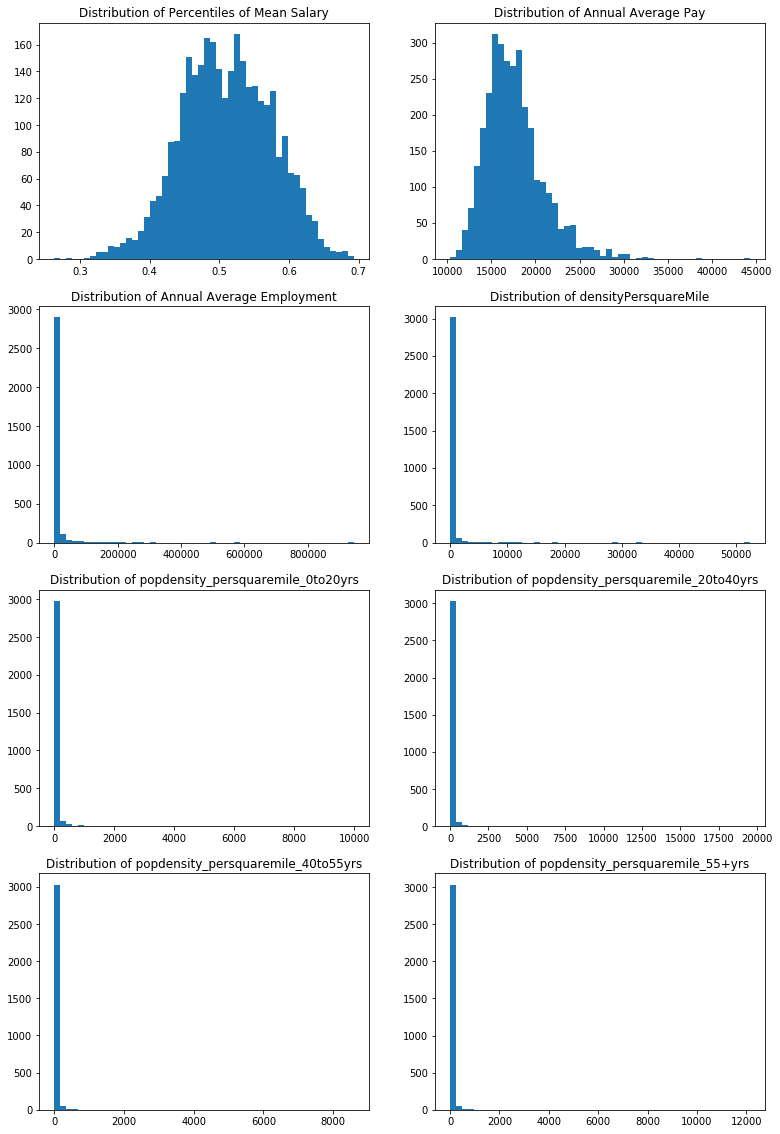

In [71]:
#Plotting the distribution of feature variables and predictor to see if there are any outliers
dist_plot(atlas_eda_df)

It can be seen that the distribution is highly skewed for some of the columns. So some of the outliers are removed. While removing, the count of the outliers dropped are taken care of.

In [72]:
print(atlas_eda_df.shape)

atlas_eda_df=atlas_eda_df[atlas_eda_df['Annual Average Employment']<90000]
print(atlas_eda_df.shape)


atlas_eda_df=atlas_eda_df[atlas_eda_df['densityPersquareMile']<10000]
print(atlas_eda_df.shape)

atlas_eda_df=atlas_eda_df[atlas_eda_df['popdensity_persquaremile_0to20yrs']<10000]
print(atlas_eda_df.shape)

atlas_eda_df=atlas_eda_df[atlas_eda_df['popdensity_persquaremile_20to40yrs']<1200]
print(atlas_eda_df.shape)

atlas_eda_df=atlas_eda_df[atlas_eda_df['popdensity_persquaremile_40to55yrs']<1200]
print(atlas_eda_df.shape)

atlas_eda_df=atlas_eda_df[atlas_eda_df['popdensity_persquaremile_55+yrs']<1200]
print(atlas_eda_df.shape)



(3124, 10)
(3081, 10)
(3079, 10)
(3079, 10)
(3065, 10)
(3065, 10)
(3065, 10)


We have dropped around 2% of the total observations. Re-plotting the distribution

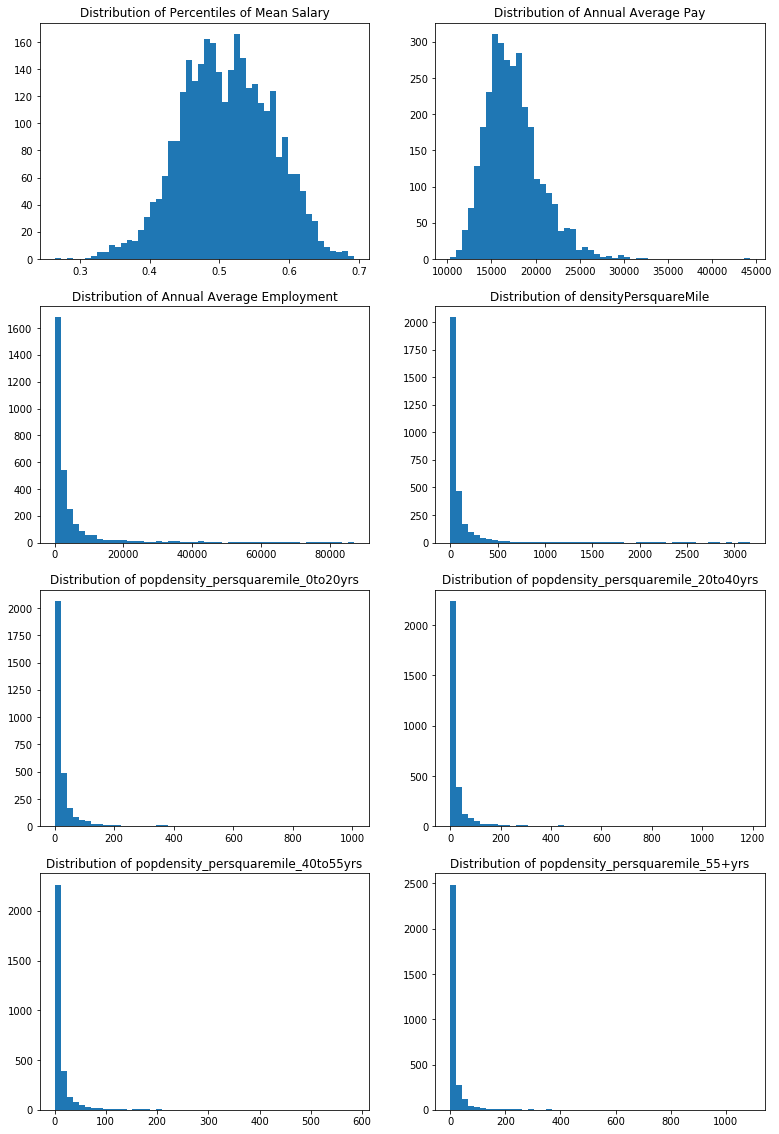

In [73]:
dist_plot(atlas_eda_df)

In [74]:
dataframe_check(atlas_eda_df)

The shape is (3065, 10)
The columns are Index(['State', 'County', 'kfr_pooled_pooled_mean', 'Annual Average Pay',
       'Annual Average Employment', 'densityPersquareMile',
       'popdensity_persquaremile_0to20yrs',
       'popdensity_persquaremile_20to40yrs',
       'popdensity_persquaremile_40to55yrs',
       'popdensity_persquaremile_55+yrs'],
      dtype='object')
**************************
Checking the NA values
State                                 3065
County                                3065
kfr_pooled_pooled_mean                3065
Annual Average Pay                    3065
Annual Average Employment             3065
densityPersquareMile                  3065
popdensity_persquaremile_0to20yrs     3065
popdensity_persquaremile_20to40yrs    3065
popdensity_persquaremile_40to55yrs    3065
popdensity_persquaremile_55+yrs       3065
dtype: int64
**************************
The Datatypes of the columns-
State                                  object
County                         

,State,County,kfr_pooled_pooled_mean,Annual Average Pay,Annual Average Employment,densityPersquareMile,popdensity_persquaremile_0to20yrs,popdensity_persquaremile_20to40yrs,popdensity_persquaremile_40to55yrs,popdensity_persquaremile_55+yrs
0,Alabama,Autauga County,0.479527,17291.823529,1698.000000,57.419463,19.611577,16.113255,8.995805,9.095218
1,Alabama,Baldwin County,0.495282,15896.882353,5909.882353,61.559662,16.736142,14.535233,7.885061,11.822424
2,Alabama,Barbour County,0.425298,16412.764706,1980.764706,28.719774,9.772881,7.558475,3.953107,6.696893
3,Alabama,Bibb County,0.446653,15541.000000,928.733333,26.632391,8.906652,7.399582,3.641951,5.597285
4,Alabama,Blount County,0.479317,16438.058824,1537.882353,60.783646,18.079604,16.827474,9.418461,12.187161


### 2.2 State-wise Employment and Annual Pay Variation 

In [77]:
def state_plots(column_name,criteria,number_ofstates):
    
    """"This is a function that plots the state wise average of the features"""

    state_avgpay=atlas_eda_df.groupby('State')[column_name].sum().sort_values(ascending=criteria).reset_index().iloc[0:number_ofstates,:]

    x=state_avgpay.State
    y=state_avgpay[column_name]

    fig, ax = plt.subplots(figsize=(10,12))    
    width = 0.75 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    ax.barh(ind, y, width)
    ax.set_yticks(ind)
    ax.set_yticklabels(x, minor=False)
    plt.title(column_name+" Variation by State")
    plt.xlabel(column_name) 
#     plt.xlim(0,1000000)
    plt.tight_layout()
#     plt.savefig('newavg_pay.png')
#     plt.savefig('top20_avgpay.png')


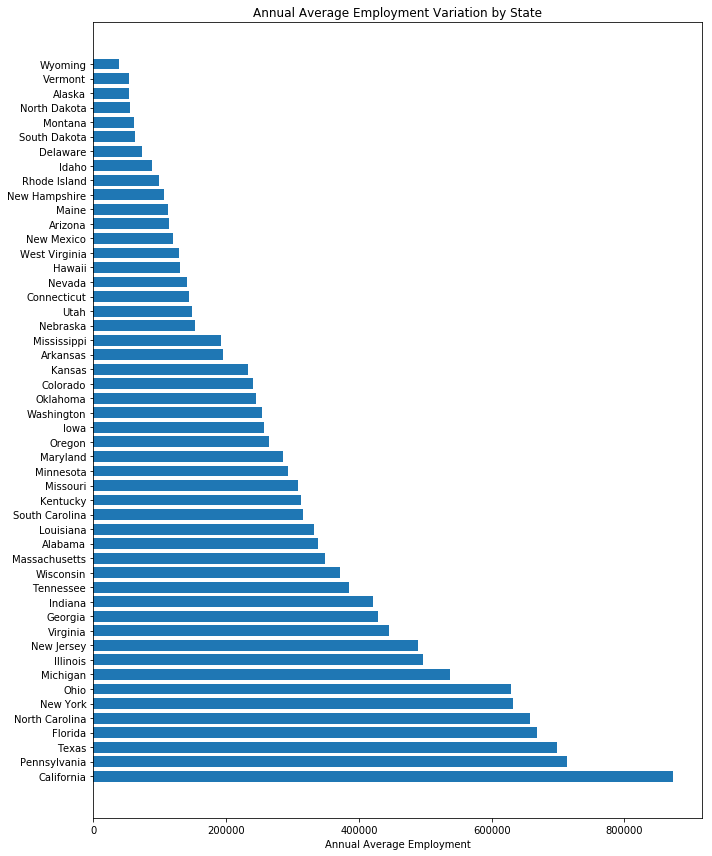

In [78]:
state_plots('Annual Average Employment',False,50)

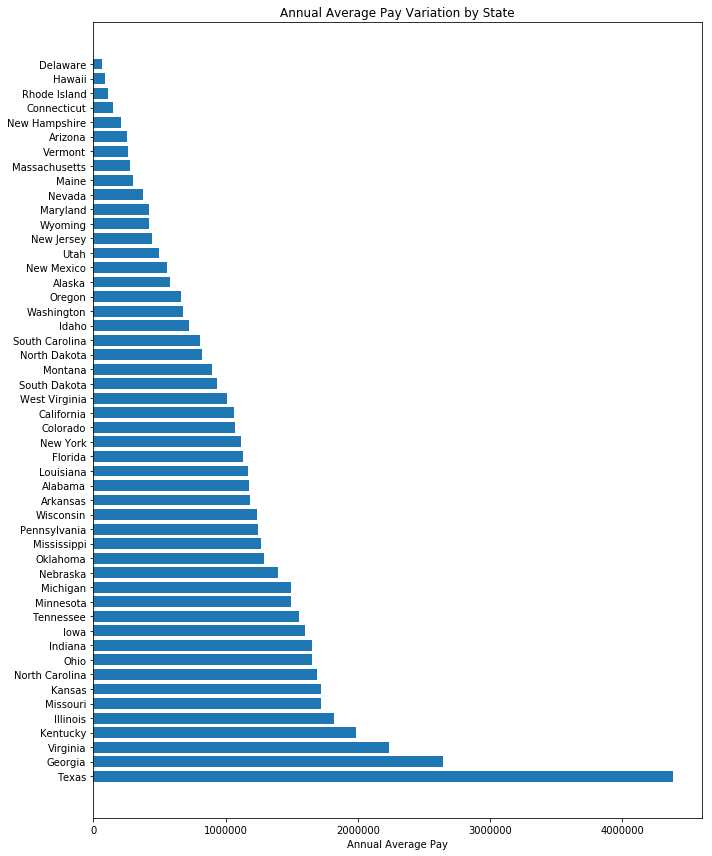

In [79]:
state_plots('Annual Average Pay',False,50)

### 2.3 County-wise plots of population density by age group, annual average pay & employment for a given state

In [80]:
def state_wise_popden_analysis(state_name,secondary_axis_label,secondary_axis, title_text):
    
 
    
    """This is a function that plots county-wise population density variation for different age 
    groups and other variables in the dataset for a given state"""  
    
    
    df=atlas_eda_df[atlas_eda_df['State']==state_name]
    df_pop=df.filter(regex='popdensity')
#     df_pop=df[['densityPersquareMile']]
    df_all=df.iloc[:,[1,5,6,7,8]]
    labels=df_all.County
    col=df_pop.columns
    width=0.5
    
    plt.figure(figsize=(16,6))
    plt.bar(labels,df[col[0]],width, label=col[0])
    plt.bar(labels,df[col[1]],width, label=col[1], bottom=df[col[0]])
    plt.bar(labels,df[col[2]],width, label=col[2], color='grey',bottom=df[col[0]]+df[col[1]])
    plt.bar(labels,df[col[3]],width, label=col[3],color='gold',bottom=df[col[0]]+df[col[1]]+df[col[2]])
    plt.legend()
    plt.title(title_text+f" in {state_name}")
    plt.ylabel("Population Density Per Square Mile")
    
    plt.xticks(range(len(labels)))
    plt.xticks(rotation=85)
    plt.title

    axes2 = plt.twinx()
    axes2.plot(labels,df[secondary_axis], 'b-')
    axes2.set_ylabel(secondary_axis_label, color='b')
    plt.tight_layout()
#     plt.savefig('newpopden_avgpay.png')
    

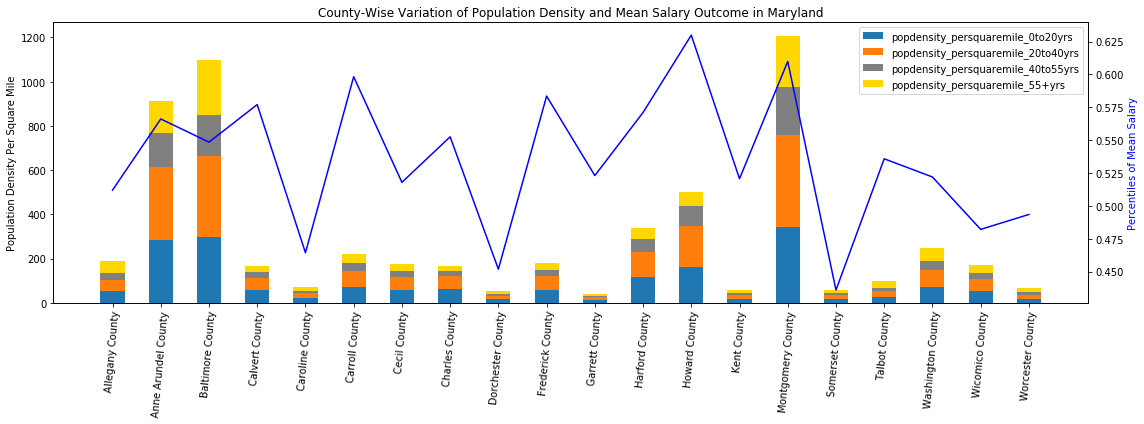

In [82]:
title_text='County-Wise Variation of Population Density and Mean Salary Outcome'
state_wise_popden_analysis('Maryland','Percentiles of Mean Salary','kfr_pooled_pooled_mean',title_text)

**Variation of population density (1980-1984) for different age groups & mean salary outcome 
(in percentile) of individuals born  in 1978-1983 in the state of Maryland**

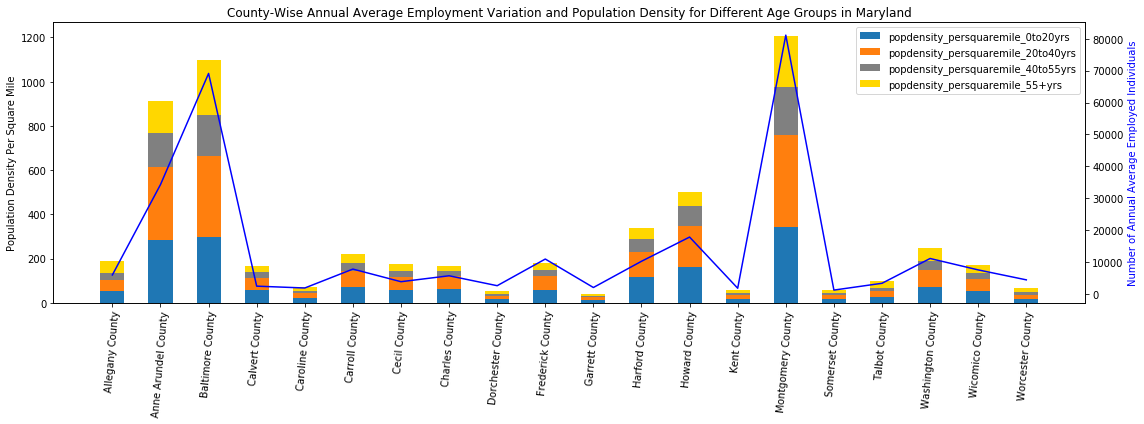

In [83]:
title_text='County-Wise Annual Average Employment Variation and Population Density for Different Age Groups'
state_wise_popden_analysis('Maryland','Number of Annual Average Employed Individuals','Annual Average Employment',title_text)

**Variation of population density (1980-1984) for different age groups & annual average employment (1990) in the state of Maryland**

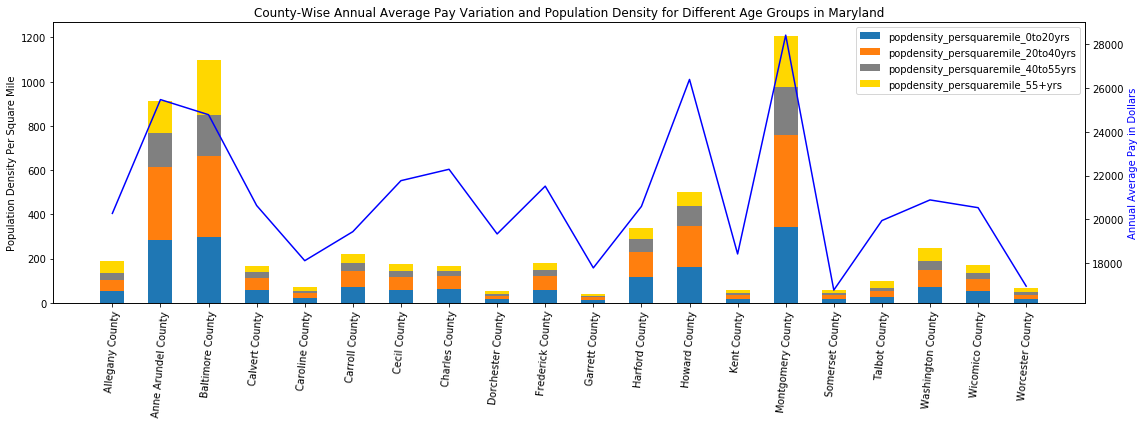

In [84]:
title_text='County-Wise Annual Average Pay Variation and Population Density for Different Age Groups'
state_wise_popden_analysis('Maryland','Annual Average Pay in Dollars','Annual Average Pay',title_text)

**Variation of population density (1980-1984) for different age groups & annual average pay (1990) in the state of Maryland**

### 2.4 County-wise plots of total population density and mean percentile salary

In [85]:
def tot_popdensity_analysis(state_name):
    
    """This is a function that plots the variation of county-wise total population density and predictor variable 
    for a given single state"""
    
    df=atlas_eda_df[atlas_eda_df['State']==state_name]
   
    df=df[['County','densityPersquareMile','kfr_pooled_pooled_mean']]
    labels=df.County
    col=df.columns
    
    width=0.5
    
    plt.figure(figsize=(16,6))
    plt.bar(labels,df[col[1]],width, label=labels, align='center')
    
    plt.xticks(rotation=85)
    plt.ylabel("Population Density Per Square Mile")
    plt.title(f'County-Wise Variation of Total Population Density & Mean Salary Outcome in {state_name} ')

    axes2 = plt.twinx()
    axes2.plot(labels,df.kfr_pooled_pooled_mean, 'r-')
    axes2.set_ylabel('Percentiles of Mean Salary', color='r')
    plt.tight_layout()
#     plt.savefig('totden_kfr.png')
    

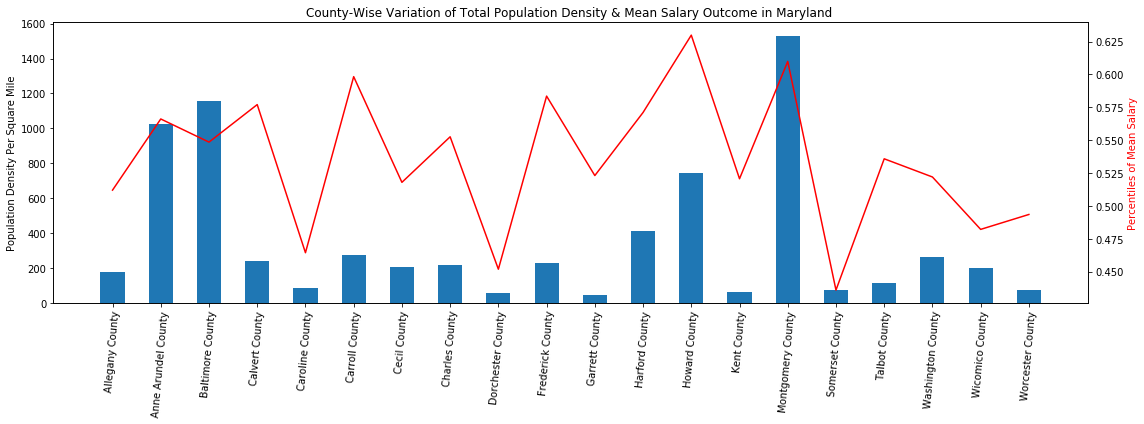

In [86]:
tot_popdensity_analysis('Maryland')

**Variation of total population density in 1990 and mean salary outcome of individuals in 2015, born  in 1978-1983 (in percentile) in the state of Maryland**

### 2.5 County-wise plots of population density for each group and mean percentile salary

In [87]:
def state_wise_popden_analysis_each_age_group(state_name,age_group_columnname):
    
    """This is a function that plots the variation of county-wise population density for each age group and predictor variable 
    for a given single state"""

    df=atlas_eda_df[atlas_eda_df['State']==state_name]

   
    df=df[['County',age_group_columnname,'kfr_pooled_pooled_mean']]
    labels=df.County
    col=df.columns

    
    width=0.5
    
    plt.figure(figsize=(16,6))
    plt.bar(labels,df[col[1]],width, label=labels, align='center')
    plt.ylim(0,400)
    age_group=age_group_columnname.split("_",2)[2]
    
    plt.xticks(rotation=85)
    plt.ylabel("Population Density Per Square Mile")
    plt.title(f'County-Wise Variation of Population Density for Age Group {age_group} & Mean Salary Outcome in {state_name} ')

    axes2 = plt.twinx()
    axes2.plot(labels,df.kfr_pooled_pooled_mean, 'r-')
    axes2.set_ylabel('Percentiles of Mean Salary', color='r')
    plt.tight_layout()
#     plt.savefig('0to20.png')
    

In [88]:
atlas_eda_df.columns

Index(['State', 'County', 'kfr_pooled_pooled_mean', 'Annual Average Pay',
       'Annual Average Employment', 'densityPersquareMile',
       'popdensity_persquaremile_0to20yrs',
       'popdensity_persquaremile_20to40yrs',
       'popdensity_persquaremile_40to55yrs',
       'popdensity_persquaremile_55+yrs'],
      dtype='object')

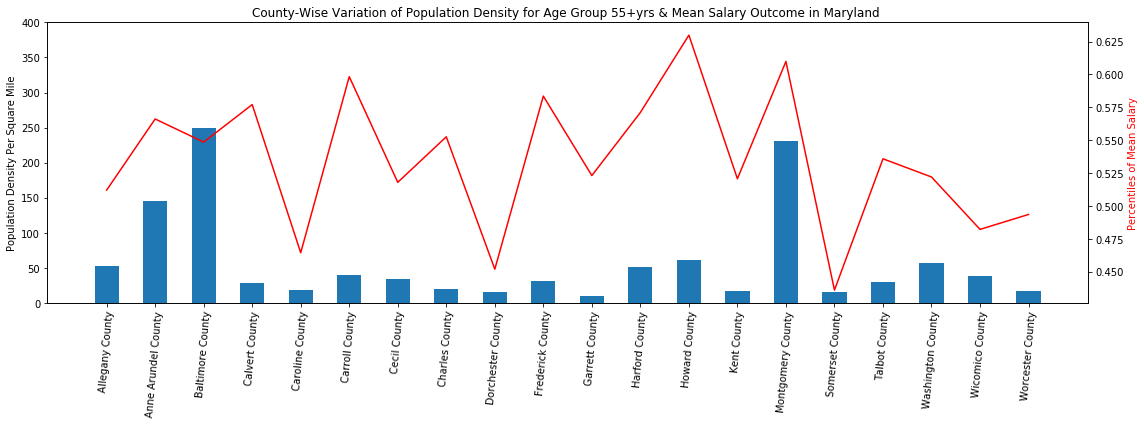

In [89]:
state_wise_popden_analysis_each_age_group('Maryland','popdensity_persquaremile_55+yrs')

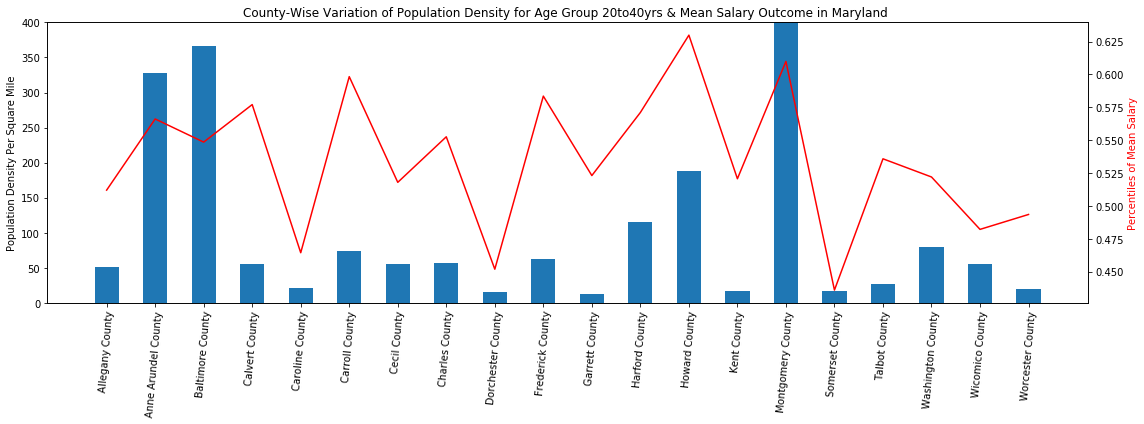

In [90]:
state_wise_popden_analysis_each_age_group('Maryland','popdensity_persquaremile_20to40yrs')

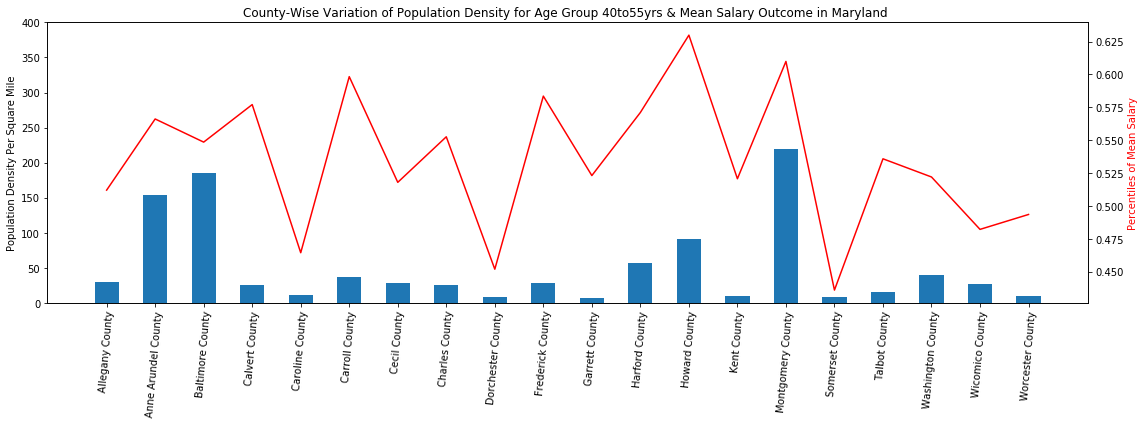

In [91]:
state_wise_popden_analysis_each_age_group('Maryland','popdensity_persquaremile_40to55yrs')

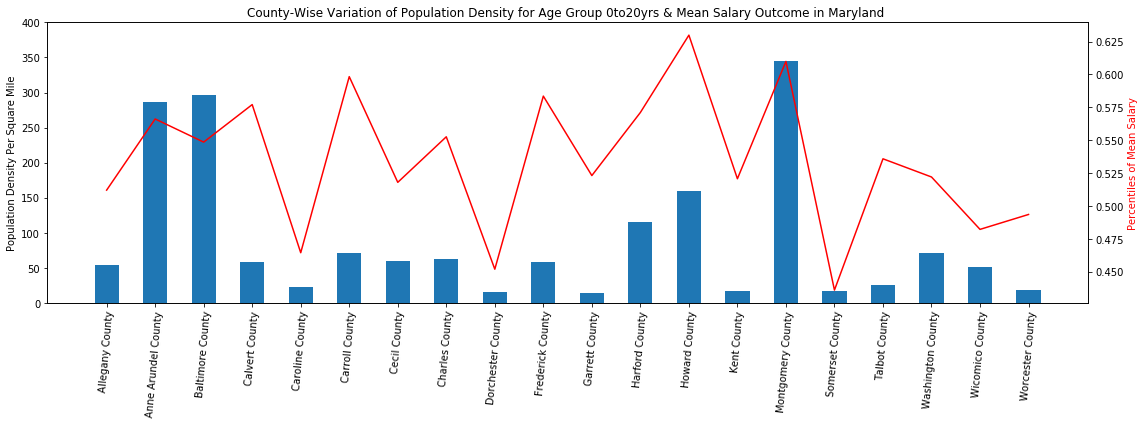

In [92]:
state_wise_popden_analysis_each_age_group('Maryland','popdensity_persquaremile_0to20yrs')

## STEP 3: Model Building
**Supervised learning:** In Supervised Learning, algorithms learn from labeled data. After understanding the data, the algorithm determines which label should be given to new data based on pattern and associating the patterns to the unlabeled new data.

**Random Forests:** A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap Aggregation, commonly known as bagging. The basic idea behind this is to combine multiple decision trees in determining the final output rather than relying on individual decision trees.

**How does the algorithm work?**
It works in four steps: 
 - Pick at random K data points from the training set
 - Build the decision tree associated with those K data points
 - Choose the number Ntree of trees you want to build and repeat step 1 & 2 
 - For a new data point, make each one of your Ntree trees predict the value of Y for the data point, and assign the new data point the average across all of the predicted Y values
 
**Advantages:**
 - Decision trees work great with the data used to create them but they are not flexible when it comes to classifying new samples or making predictions 
 - Random forests combine the simplicity of decision trees with flexibility resulting in more accuracy

**Disadvantages:**
 - The main disadvantage of Random forests is their complexity 
 - They are much harder and time-consuming to construct than decision trees 
 - In addition, the prediction process using random forests is time-consuming than other algorithms
 
**Ridge Regression**

Ridge Regression is a technique for analyzing multiple regression data that suffer from multicollinearity. When multicollinearity occurs, least squares estimates are unbiased, but their variances are large so they may be far from the true value.


In [93]:
atlas_eda_df.columns

Index(['State', 'County', 'kfr_pooled_pooled_mean', 'Annual Average Pay',
       'Annual Average Employment', 'densityPersquareMile',
       'popdensity_persquaremile_0to20yrs',
       'popdensity_persquaremile_20to40yrs',
       'popdensity_persquaremile_40to55yrs',
       'popdensity_persquaremile_55+yrs'],
      dtype='object')

In [94]:

model_df=atlas_eda_df[['kfr_pooled_pooled_mean','Annual Average Pay','Annual Average Employment','densityPersquareMile','popdensity_persquaremile_0to20yrs',
       'popdensity_persquaremile_20to40yrs',
       'popdensity_persquaremile_40to55yrs',
       'popdensity_persquaremile_55+yrs']]


### Checking the data

In [95]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3065 entries, 0 to 3123
Data columns (total 8 columns):
kfr_pooled_pooled_mean                3065 non-null float64
Annual Average Pay                    3065 non-null float64
Annual Average Employment             3065 non-null float64
densityPersquareMile                  3065 non-null float64
popdensity_persquaremile_0to20yrs     3065 non-null float64
popdensity_persquaremile_20to40yrs    3065 non-null float64
popdensity_persquaremile_40to55yrs    3065 non-null float64
popdensity_persquaremile_55+yrs       3065 non-null float64
dtypes: float64(8)
memory usage: 215.5 KB


In [96]:
dataframe_check(model_df)

The shape is (3065, 8)
The columns are Index(['kfr_pooled_pooled_mean', 'Annual Average Pay',
       'Annual Average Employment', 'densityPersquareMile',
       'popdensity_persquaremile_0to20yrs',
       'popdensity_persquaremile_20to40yrs',
       'popdensity_persquaremile_40to55yrs',
       'popdensity_persquaremile_55+yrs'],
      dtype='object')
**************************
Checking the NA values
kfr_pooled_pooled_mean                3065
Annual Average Pay                    3065
Annual Average Employment             3065
densityPersquareMile                  3065
popdensity_persquaremile_0to20yrs     3065
popdensity_persquaremile_20to40yrs    3065
popdensity_persquaremile_40to55yrs    3065
popdensity_persquaremile_55+yrs       3065
dtype: int64
**************************
The Datatypes of the columns-
kfr_pooled_pooled_mean                float64
Annual Average Pay                    float64
Annual Average Employment             float64
densityPersquareMile                  float64

,kfr_pooled_pooled_mean,Annual Average Pay,Annual Average Employment,densityPersquareMile,popdensity_persquaremile_0to20yrs,popdensity_persquaremile_20to40yrs,popdensity_persquaremile_40to55yrs,popdensity_persquaremile_55+yrs
0,0.479527,17291.823529,1698.000000,57.419463,19.611577,16.113255,8.995805,9.095218
1,0.495282,15896.882353,5909.882353,61.559662,16.736142,14.535233,7.885061,11.822424
2,0.425298,16412.764706,1980.764706,28.719774,9.772881,7.558475,3.953107,6.696893
3,0.446653,15541.000000,928.733333,26.632391,8.906652,7.399582,3.641951,5.597285
4,0.479317,16438.058824,1537.882353,60.783646,18.079604,16.827474,9.418461,12.187161


### Selecting Feature and Target Variables
**Features:** A feature is an individual measurable property or characteristic of a phenomenon being observed

**Targets:** The target variable is the variable whose values are to be modeled and predicted by other variables



In [97]:
Xdata=model_df.drop(['kfr_pooled_pooled_mean'],axis=1)
ydata=model_df['kfr_pooled_pooled_mean']


### Scaling the data
Most of the times, the dataset will contain features highly varying in magnitudes, units and range. But since, most of the machine learning algorithms use Eucledian distance between two data points in their computations, this is a problem. If left alone, these algorithms only take in the magnitude of features neglecting the units. The results would vary greatly between different units. To supress this effect, we need to bring all features to the same level of magnitudes. This can be acheived by scaling.

**Min-Max Scaling:**
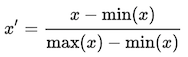

This scaling brings the value between 0 and 1.

In [98]:
def minmax(x):
    
    ### Function to scale the data between 0 and 1
    
    c=[]
    min_value=x.min()
    range_value=x.max()-x.min()
    return (x-min_value)/range_value
        

In [99]:
for i in Xdata.columns:
    Xdata[i]=minmax(Xdata[i])

In [100]:
Xdata.head()

,Annual Average Pay,Annual Average Employment,densityPersquareMile,popdensity_persquaremile_0to20yrs,popdensity_persquaremile_20to40yrs,popdensity_persquaremile_40to55yrs,popdensity_persquaremile_55+yrs
0,0.204991,0.019318,0.018126,0.019469,0.013530,0.015365,0.008359
1,0.163916,0.067619,0.019434,0.016612,0.012203,0.013466,0.010867
2,0.179106,0.022560,0.009058,0.009692,0.006338,0.006745,0.006154
3,0.153436,0.010496,0.008398,0.008831,0.006205,0.006213,0.005143
4,0.179851,0.017481,0.019189,0.017947,0.014130,0.016087,0.011202


### Preparing Train and test data
**Training Data and Testing Data:**
The data set is to be split into two subsets called training data and testing data. 
- Training data is the data set which is already labeled and is used to train a model 
- Testing data is the data set which has to be labeled and a used to test the trained model

In python, we use the sklearn.model_selection.train_test_split() to split the arrays or matrices into random train and test subsets test_size=0.25 means that 25% of the data has been assigned as test data and 75% as training data.

In [101]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state = 25)

In [102]:
Xtrain=np.array(Xtrain)
Xtest=np.array(Xtest)
ytrain=np.array(ytrain)
ytest=np.array(ytest)

### Ridge Regression
Ran k-fold cross validation with k=5

In [103]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
num_folds = 5
k_fold = KFold(num_folds)
max_cross_depth_score = -np.inf
for alpha in np.arange(0,5,0.1):
        fold_scores = []
        print("Alpha = %.2f " %(alpha))
        for k, (train, val) in enumerate(k_fold.split(Xtrain, ytrain)):
            ridge_unreg = Ridge()
            ridge_unreg.set_params(alpha=alpha)
            ridge_unreg.fit(Xtrain[train], ytrain[train])

            ypred = ridge_unreg.predict(Xtrain[val])
            yval = ytrain[val]
            Rsquare = r2_score(yval, ypred)
            fold_scores.append(Rsquare)
        
            print("\t[fold {0}] Alpha: {1:.2f}, Rsquare: {2:.5f}".
                  format(k, alpha, Rsquare))

        cross_val_score = np.mean(fold_scores)
        if cross_val_score > max_cross_depth_score:
            max_cross_depth_score = cross_val_score
            arg_max = alpha

Alpha = 0.00 
	[fold 0] Alpha: 0.00, Rsquare: 0.00141
	[fold 1] Alpha: 0.00, Rsquare: 0.03256
	[fold 2] Alpha: 0.00, Rsquare: 0.01510
	[fold 3] Alpha: 0.00, Rsquare: 0.02704
	[fold 4] Alpha: 0.00, Rsquare: -0.00093
Alpha = 0.10 
	[fold 0] Alpha: 0.10, Rsquare: 0.01590
	[fold 1] Alpha: 0.10, Rsquare: 0.02650
	[fold 2] Alpha: 0.10, Rsquare: 0.02626
	[fold 3] Alpha: 0.10, Rsquare: 0.01952
	[fold 4] Alpha: 0.10, Rsquare: 0.00025
Alpha = 0.20 
	[fold 0] Alpha: 0.20, Rsquare: 0.01106
	[fold 1] Alpha: 0.20, Rsquare: 0.02345
	[fold 2] Alpha: 0.20, Rsquare: 0.02462
	[fold 3] Alpha: 0.20, Rsquare: 0.01608
	[fold 4] Alpha: 0.20, Rsquare: -0.00121
Alpha = 0.30 
	[fold 0] Alpha: 0.30, Rsquare: 0.00815
	[fold 1] Alpha: 0.30, Rsquare: 0.02163
	[fold 2] Alpha: 0.30, Rsquare: 0.02293
	[fold 3] Alpha: 0.30, Rsquare: 0.01412
	[fold 4] Alpha: 0.30, Rsquare: -0.00208
Alpha = 0.40 
	[fold 0] Alpha: 0.40, Rsquare: 0.00628
	[fold 1] Alpha: 0.40, Rsquare: 0.02040
	[fold 2] Alpha: 0.40, Rsquare: 0.02165
	[fold 

	[fold 1] Alpha: 4.40, Rsquare: 0.01269
	[fold 2] Alpha: 4.40, Rsquare: 0.01356
	[fold 3] Alpha: 4.40, Rsquare: 0.00695
	[fold 4] Alpha: 4.40, Rsquare: -0.00064
Alpha = 4.50 
	[fold 0] Alpha: 4.50, Rsquare: 0.00093
	[fold 1] Alpha: 4.50, Rsquare: 0.01263
	[fold 2] Alpha: 4.50, Rsquare: 0.01349
	[fold 3] Alpha: 4.50, Rsquare: 0.00692
	[fold 4] Alpha: 4.50, Rsquare: -0.00058
Alpha = 4.60 
	[fold 0] Alpha: 4.60, Rsquare: 0.00095
	[fold 1] Alpha: 4.60, Rsquare: 0.01256
	[fold 2] Alpha: 4.60, Rsquare: 0.01342
	[fold 3] Alpha: 4.60, Rsquare: 0.00688
	[fold 4] Alpha: 4.60, Rsquare: -0.00052
Alpha = 4.70 
	[fold 0] Alpha: 4.70, Rsquare: 0.00097
	[fold 1] Alpha: 4.70, Rsquare: 0.01249
	[fold 2] Alpha: 4.70, Rsquare: 0.01335
	[fold 3] Alpha: 4.70, Rsquare: 0.00685
	[fold 4] Alpha: 4.70, Rsquare: -0.00046
Alpha = 4.80 
	[fold 0] Alpha: 4.80, Rsquare: 0.00099
	[fold 1] Alpha: 4.80, Rsquare: 0.01243
	[fold 2] Alpha: 4.80, Rsquare: 0.01328
	[fold 3] Alpha: 4.80, Rsquare: 0.00681
	[fold 4] Alpha: 4.8

### Running k fold cross validated Random forest & derive the best hyperparameters 

In [104]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
num_folds = 5
k_fold = KFold(num_folds)
max_cross_depth_score = -np.inf
estimator_max=0

for i in range(100,500,100):
    print("Estimator = ",i)
    for depth in range(6,25,1):
        fold_scores = []
        print("Depth = %.2f " %(depth))
        for k, (train, val) in enumerate(k_fold.split(Xtrain, ytrain)):
            clf_un = RandomForestRegressor(max_depth = depth,n_estimators=i)
            clf_un.fit(Xtrain[train], ytrain[train])

            ypred = clf_un.predict(Xtrain[val])
            yval = ytrain[val]
            Rsquare = r2_score(yval, ypred)
            fold_scores.append(Rsquare)
        
            print("\t[fold {0}] Depth: {1:.2f}, Rsquare: {2:.5f}".
                  format(k, depth, Rsquare))

        cross_val_score = np.mean(fold_scores)
        if cross_val_score > max_cross_depth_score:
            max_cross_depth_score = cross_val_score
            arg_max = depth
            estimator_max=i   

    

best_estimator=estimator_max
best_depth = arg_max
print('\nRandom Forest Best Depth:',best_depth)
print('\nRandom Forest Best Estimator:',best_estimator)

Estimator =  100
Depth = 6.00 
	[fold 0] Depth: 6.00, Rsquare: 0.25534
	[fold 1] Depth: 6.00, Rsquare: 0.19314
	[fold 2] Depth: 6.00, Rsquare: 0.21432
	[fold 3] Depth: 6.00, Rsquare: 0.23068
	[fold 4] Depth: 6.00, Rsquare: 0.25726
Depth = 7.00 
	[fold 0] Depth: 7.00, Rsquare: 0.27065
	[fold 1] Depth: 7.00, Rsquare: 0.20055
	[fold 2] Depth: 7.00, Rsquare: 0.21410
	[fold 3] Depth: 7.00, Rsquare: 0.23999
	[fold 4] Depth: 7.00, Rsquare: 0.26016
Depth = 8.00 
	[fold 0] Depth: 8.00, Rsquare: 0.28769
	[fold 1] Depth: 8.00, Rsquare: 0.21053
	[fold 2] Depth: 8.00, Rsquare: 0.20083
	[fold 3] Depth: 8.00, Rsquare: 0.23740
	[fold 4] Depth: 8.00, Rsquare: 0.27842
Depth = 9.00 
	[fold 0] Depth: 9.00, Rsquare: 0.29085
	[fold 1] Depth: 9.00, Rsquare: 0.21750
	[fold 2] Depth: 9.00, Rsquare: 0.21194
	[fold 3] Depth: 9.00, Rsquare: 0.25105
	[fold 4] Depth: 9.00, Rsquare: 0.28122
Depth = 10.00 
	[fold 0] Depth: 10.00, Rsquare: 0.29933
	[fold 1] Depth: 10.00, Rsquare: 0.21397
	[fold 2] Depth: 10.00, Rsquar

	[fold 2] Depth: 24.00, Rsquare: 0.19065
	[fold 3] Depth: 24.00, Rsquare: 0.25413
	[fold 4] Depth: 24.00, Rsquare: 0.28861
Estimator =  300
Depth = 6.00 
	[fold 0] Depth: 6.00, Rsquare: 0.25976
	[fold 1] Depth: 6.00, Rsquare: 0.18876
	[fold 2] Depth: 6.00, Rsquare: 0.21063
	[fold 3] Depth: 6.00, Rsquare: 0.22900
	[fold 4] Depth: 6.00, Rsquare: 0.25657
Depth = 7.00 
	[fold 0] Depth: 7.00, Rsquare: 0.27599
	[fold 1] Depth: 7.00, Rsquare: 0.19991
	[fold 2] Depth: 7.00, Rsquare: 0.21379
	[fold 3] Depth: 7.00, Rsquare: 0.24204
	[fold 4] Depth: 7.00, Rsquare: 0.26947
Depth = 8.00 
	[fold 0] Depth: 8.00, Rsquare: 0.28543
	[fold 1] Depth: 8.00, Rsquare: 0.21713
	[fold 2] Depth: 8.00, Rsquare: 0.20543
	[fold 3] Depth: 8.00, Rsquare: 0.24642
	[fold 4] Depth: 8.00, Rsquare: 0.27548
Depth = 9.00 
	[fold 0] Depth: 9.00, Rsquare: 0.28968
	[fold 1] Depth: 9.00, Rsquare: 0.21964
	[fold 2] Depth: 9.00, Rsquare: 0.20832
	[fold 3] Depth: 9.00, Rsquare: 0.25338
	[fold 4] Depth: 9.00, Rsquare: 0.28561
Dept

	[fold 4] Depth: 23.00, Rsquare: 0.29709
Depth = 24.00 
	[fold 0] Depth: 24.00, Rsquare: 0.29769
	[fold 1] Depth: 24.00, Rsquare: 0.21757
	[fold 2] Depth: 24.00, Rsquare: 0.20037
	[fold 3] Depth: 24.00, Rsquare: 0.25464
	[fold 4] Depth: 24.00, Rsquare: 0.28237

Random Forest Best Depth: 12

Random Forest Best Estimator: 400


### Using the hyperparameters to build the model

In [105]:
clf_sm = RandomForestRegressor(random_state = 7 , max_depth=best_depth,n_estimators=best_estimator)
clf_sm.fit(Xtrain, ytrain)
ypred_rf = clf_sm.predict(Xtest)

## STEP 4: MODEL EVALUATION

**Coefficient of Determination(R2):**  It is the proportion of variation in the outcome that is explained by the predictor variables. In multiple regression models, R2 corresponds to the squared correlation between the observed outcome values and the predicted values by the model. 

The Higher the R-squared, the better the model.



In [106]:
#Print a few predictions
print((pd.DataFrame(ypred_rf, columns={'y_prediction'}).head(5)))
print()


#Performance Metric: Mean Squared Error
# print("Mean Squared Error (MSE):%.2f" % mean_squared_error(ytest, ypred_rf))
print()

# Explained variance score:
print('Variance Score (R^2):%.2f' % r2_score(ytest, ypred_rf))
print()

   y_prediction
0      0.491905
1      0.524237
2      0.573038
3      0.536694
4      0.464711


Variance Score (R^2):0.30



**From the results, we can conclude that Population density and employment data, taken together explains 30% of variance in the future mean salary outcome of children born between 1978-1983**

### Residual Plot

Text(0.5,1,'Histogram of Residuals')

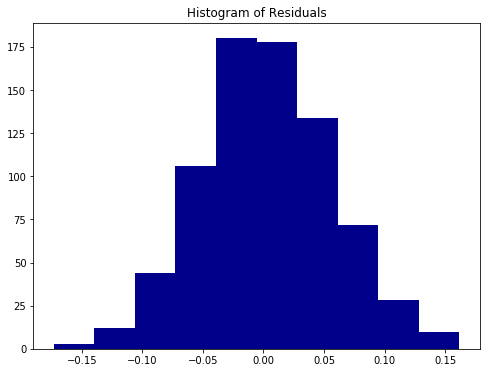

In [107]:
residuals=ytest-ypred_rf
plt.figure(figsize=(8,6))
plt.hist(residuals, color='darkblue')
plt.title("Histogram of Residuals")

In [108]:
features = Xdata.columns
importances = clf_sm.feature_importances_
indices = np.argsort(importances)

important_features = {}
for idx in indices:
     if(importances[idx] > 0):
        important_features[features[idx]] = importances[idx]

In [109]:
clf_sm.feature_importances_

array([0.2349937 , 0.1185621 , 0.1637987 , 0.13841857, 0.08478401,
       0.10190595, 0.15753698])

### Important Features

**Feature Importance:** Random forests are among the most popular machine learning methods thanks to their relatively good accuracy, robustness and ease of use. They also provide two straightforward methods for feature selection: mean decrease impurity and mean decrease accuracy. Random Forests and Decision Trees implicitly perform feature selection. One advantage of random forests is we can know which feature is the most suitable one to perform either
regression or classification.

### Visualizing the features: 
Results are always better if they are presented visually instead of presenting the numeric values. So let’s take a look at the important features with the help of a graph.

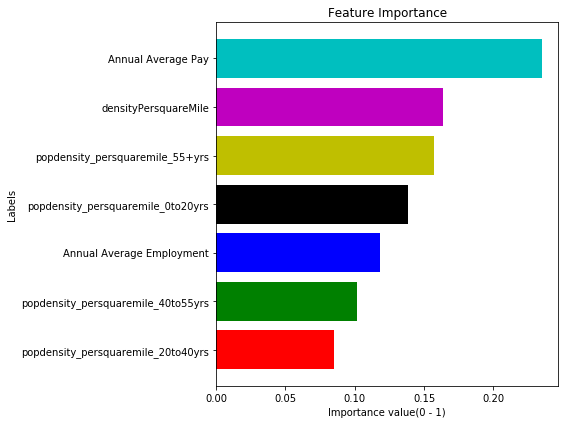

In [110]:
plt.figure(figsize=(8,6))
plt.barh(range(len(important_features)), list(important_features.values()), align='center',color='rgbkymc')
plt.yticks(range(len(important_features)), list(important_features.keys()))
plt.title("Feature Importance")
plt.xlabel("Importance value(0 - 1)")
plt.ylabel("Labels")
plt.tight_layout()
# plt.show()
plt.savefig('featureimp.png')

- **Annual Average Pay holds the highest importance as expected**
- **It is interesting to see that the importance of 55+ age group individuals is higher compared to Annual Average Employment and the population density of other age group individuals**

## Conclusions:
1. Population density and employment data, taken together explains 30% of variance in the future mean salary outcome of children born between 1978-1983
2. Possibility of a child having a better economic condition in the future increases with more 55+ age group individuals in the county
3. Higher the average pay in a county, higher are the possibilities of a bright economic condition of the child
